In [13]:
from tensorflow.keras.datasets.cifar10 import load_data
from matplotlib import pyplot
import tensorflow as tf 
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten, Conv2DTranspose, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint

In [4]:

(train_X,train_y), (test_X, test_y) = load_data() 

print('Train', train_X.shape, train_y.shape)
print('Train', test_X.shape, train_y.shape)

Train (50000, 32, 32, 3) (50000, 1)
Train (10000, 32, 32, 3) (50000, 1)


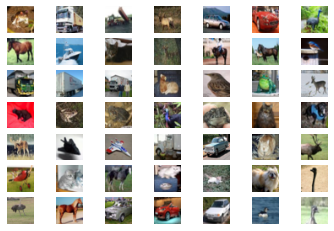

In [5]:
for i in range(49):
    pyplot.subplot(7,7,1+i)
    pyplot.axis('off')
    pyplot.imshow(train_X[i])
pyplot.show()

In [7]:
def discriminator(in_shape=(32,32,3)):
    model = Sequential()
    #normal
    model.add(Conv2D(64,(3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    #downsample
    model.add(Conv2D(128,(3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    #downsample
    model.add(Conv2D(128,(3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    #downsample
    model.add(Conv2D(256,(3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    #classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    #compile
    opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# model = discriminator()
# model.summary()
# plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

Model: &quot;sequential_1&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 25

In [9]:
#load and prepare cifar10 training images
def load_real_samples():
    #load cifar10 samples
    (trainX,_),(_,_) = load_data()
    X= trainX.astype('float32')
    X = (X-127.5)/127.5
    return X

In [24]:
#real sample selection
def generate_real_samples(dataset, n_samples):
    #choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    #retrieve selected images
    X = dataset[ix]
    #generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y 

In [19]:
#generate n fake samples with class labels to train discriminator beforehand
def generate_fake_samples(n_samples):
    #generate uniform random numbers in [0,1]
    X = rand(32*32*3*n_samples)
    #update to have the range[-1,1]
    X = -1 + X*2
    # reshape into a batch of color images
    X = X.reshape((n_samples, 32, 32, 3))
    # generate 'fake' class labels (0)
    y = zeros((n_samples,1))
    return X, y



(array([[[[-0.86853175,  0.96532698,  0.93780003],
          [-0.28022952, -0.24245161, -0.60459721],
          [ 0.40664881,  0.9443166 , -0.23791239],
          ...,
          [-0.65368878, -0.28879575,  0.02228244],
          [ 0.22705426,  0.94300273,  0.87319816],
          [ 0.11718444,  0.01104264,  0.1381394 ]],
 
         [[-0.81308274, -0.36768563, -0.67502789],
          [ 0.09533686, -0.99923474, -0.65556685],
          [-0.3744718 , -0.83450118, -0.14522836],
          ...,
          [-0.33196043,  0.74631968, -0.37135976],
          [ 0.49563201,  0.66552028, -0.12419312],
          [ 0.784627  , -0.29171838, -0.46237699]],
 
         [[ 0.72275587, -0.59926449,  0.73162887],
          [ 0.18755112, -0.00560857,  0.59176218],
          [ 0.92440774, -0.59346647, -0.52768513],
          ...,
          [-0.24891215, -0.15579044, -0.10579302],
          [ 0.36460065, -0.12231794,  0.50136242],
          [-0.43170634,  0.48056024, -0.93048506]],
 
         ...,
 
         [[ 

In [20]:
#train the discriminator
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
    half_batch = int(n_batch/2)
    #manually enumerate epochs 
    for i in range(n_iter):
        #get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        #generate fake examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        #update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        #summarize
        print('>%d real=%.0f%% fake=%.0f%%' %(i+1, real_acc*100, fake_acc*100))



In [26]:
model = discriminator()
dataset = load_real_samples()
train_discriminator(model, dataset)

&gt;1 real=34% fake=0%
&gt;2 real=95% fake=8%
&gt;3 real=98% fake=20%
&gt;4 real=97% fake=53%
&gt;5 real=95% fake=83%
&gt;6 real=88% fake=100%
&gt;7 real=97% fake=100%
&gt;8 real=95% fake=100%
&gt;9 real=91% fake=100%
&gt;10 real=86% fake=100%
&gt;11 real=97% fake=100%
&gt;12 real=95% fake=100%
&gt;13 real=98% fake=100%
&gt;14 real=98% fake=100%
&gt;15 real=100% fake=100%
&gt;16 real=98% fake=100%
&gt;17 real=100% fake=100%
&gt;18 real=100% fake=100%
&gt;19 real=100% fake=100%
&gt;20 real=100% fake=100%
